# Imports

In [92]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import datetime as dt

# Data

## Public

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# AMWA
amwa_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/Kml Ruta AMVA'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        amwa_bus_routes = gpd.GeoDataFrame(pd.concat([amwa_bus_routes, df], ignore_index=True))
amwa_bus_routes.reset_index(inplace=True)
amwa_bus_routes['carrier'] = 'AMWA'

# SMM
smm_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/kml Ruta SMM'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        
smm_bus_routes.reset_index(inplace=True)
smm_bus_routes['carrier'] = 'SMM'

# METRO
metro_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/medellin_metro/medellin_metro_stations'):
    for file in files:
        path = os.path.join(root, file)
        kmz = ZipFile(path, 'r')
        kml = kmz.open('doc.kml', 'r')
        df = gpd.read_file(kml, driver='KML')
        metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
metro_routes.reset_index(inplace=True)

all_dfs = [metro_routes, smm_bus_routes, amwa_bus_routes]
all_routes = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True))

# TEST
all_routes['carrier'].value_counts()

SMM     11297
AMWA      270
Name: carrier, dtype: int64

## Bike stations

In [79]:
bike_df = pd.read_csv('raw_data/bike_loans.csv', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario'])
bike_df['Fecha_Prestamo'] = bike_df['Fecha_Prestamo'].astype('datetime64[ns]')
bike_df['Fecha_Devolucion'] = bike_df['Fecha_Devolucion'].astype('datetime64[ns]')

bike_df.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

In [166]:
bike_df = bike_df.dropna()

# Cut df

In [119]:
# filter pre covid
bike_df['Fecha_Devolucion'].max()

Timestamp('2021-04-21 05:19:08')

In [82]:
bike_df.sample(20)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist
13530439,16526609,128020,0000343B8DE2,2020-12-03 12:55:27,2020-12-03 13:14:56,59,4,97.0,12.0,1676.0
2863046,1627239,38897,000017AFD58C,2016-02-19 16:13:42,2016-02-19 16:27:54,56,14,41.0,18.0,1532.0
10809583,13406049,25862,00D567222B5E,2019-09-30 17:57:42,2019-09-30 18:06:14,40,1,8.0,1.0,1603.0
7169086,9696247,28151,0000190AF7B3,2018-09-13 17:10:15,2018-09-13 17:27:09,58,1,6.0,1.0,1689.0
4176389,6407619,99537,0000182A3171,2017-06-06 17:22:41,2017-06-06 17:58:41,1,1,60.0,20.0,762.0
1493942,5698592,94933,000017B03709,2017-02-27 10:05:49,2017-02-27 10:13:08,70,1,7.0,1.0,1140.0
1424127,5675900,46354,000017B03B19,2017-02-23 11:42:16,2017-02-23 11:49:08,10,1,46.0,11.0,1528.0
12879503,15827207,116643,0000EE236DCD,2020-07-16 15:57:57,2020-07-16 17:38:09,57,22,101.0,10.0,2867.0
12019687,14763778,1384,00006685CE0A,2020-01-30 11:54:25,2020-01-30 12:02:20,39,1,8.0,1.0,1427.0
3353284,6600054,22128,0000164BDAA2,2017-07-11 07:03:09,2017-07-11 07:17:18,12,1,5.0,1.0,1109.0


In [83]:
# Id_Historico_Prestamo = almost unique => remove duplicates

In [84]:
print(f'In total we have {len(bike_df.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 6698 unique bikes over all recorded time


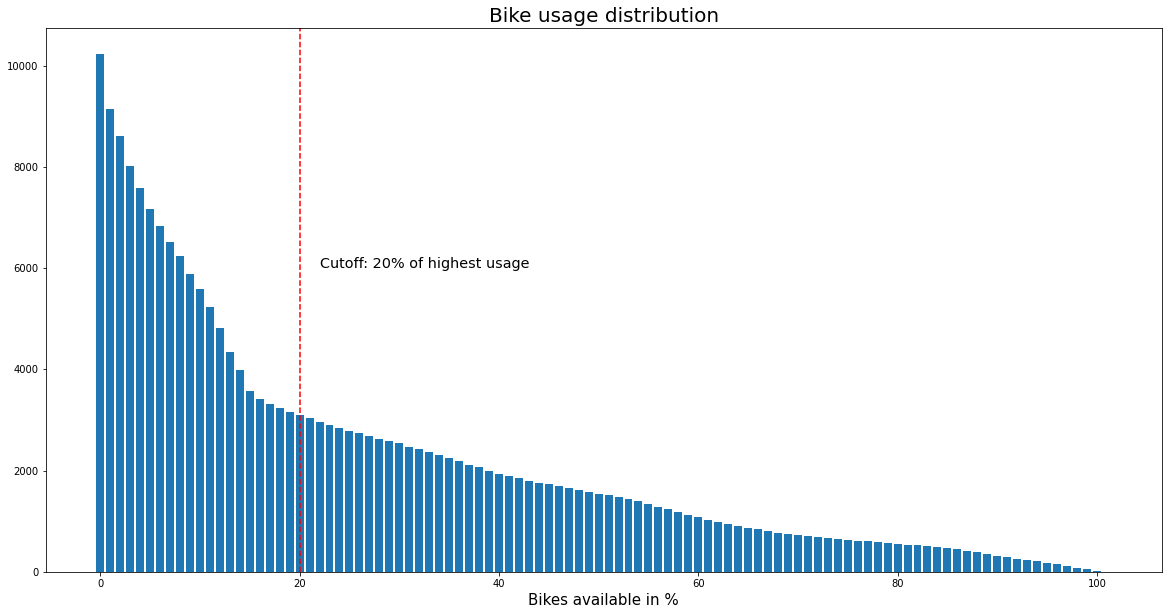

In [85]:
# how is the usage of each bike distributed
# .hist() doesn't work
plt.figure(figsize=(20,10))
plt.title('Bike usage distribution', size=20)
counts = bike_df.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(20, color='r', linestyle='--')

plt.show()

# Most used routes

In [163]:
bike_df['hour'] = bike_df.Fecha_Prestamo.dt.hour

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,hour
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,929.0,14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,1612.0,14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,1679.0,14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,1076.0,13
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,1176.0,14
...,...,...,...,...,...,...,...,...,...,...,...
14225350,17272860,26650,00001B7DE4E2,2021-04-20 18:46:57,2021-04-20 19:07:25,45,18,89.0,11.0,NaN,18
14225351,17272686,151968,000030778CC7,2021-04-20 18:28:09,2021-04-20 19:08:00,96,20,96.0,15.0,3525.0,18
14225352,17272992,155196,000037FDF432,2021-04-20 18:59:53,2021-04-20 19:08:59,56,37,89.0,15.0,NaN,18
14225353,17272844,144508,000026B3E61C,2021-04-20 18:45:42,2021-04-20 19:13:45,61,1,1.0,1.0,1430.0,18


In [167]:
bike_df['routes'] = bike_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)

<ipython-input-167-5b16348eba3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['routes'] = bike_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)


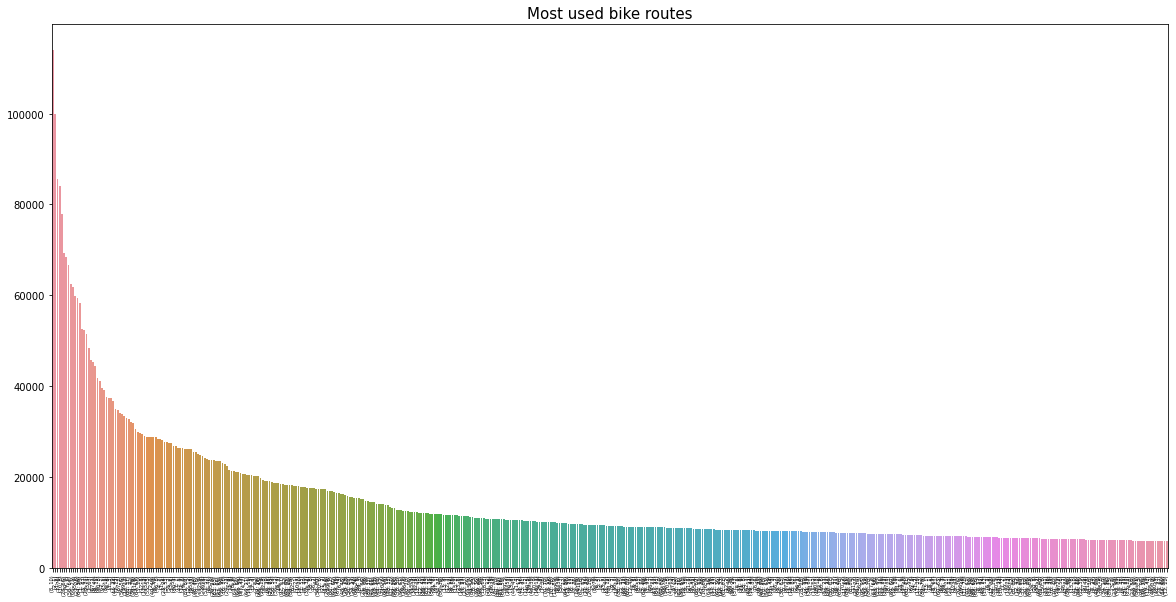

In [211]:
counts = bike_df.routes.value_counts()[:500]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.title('Most used bike routes', size=15)
plt.xticks(rotation=90, size=5)
plt.show()

In [173]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bike_df.groupby('hour').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

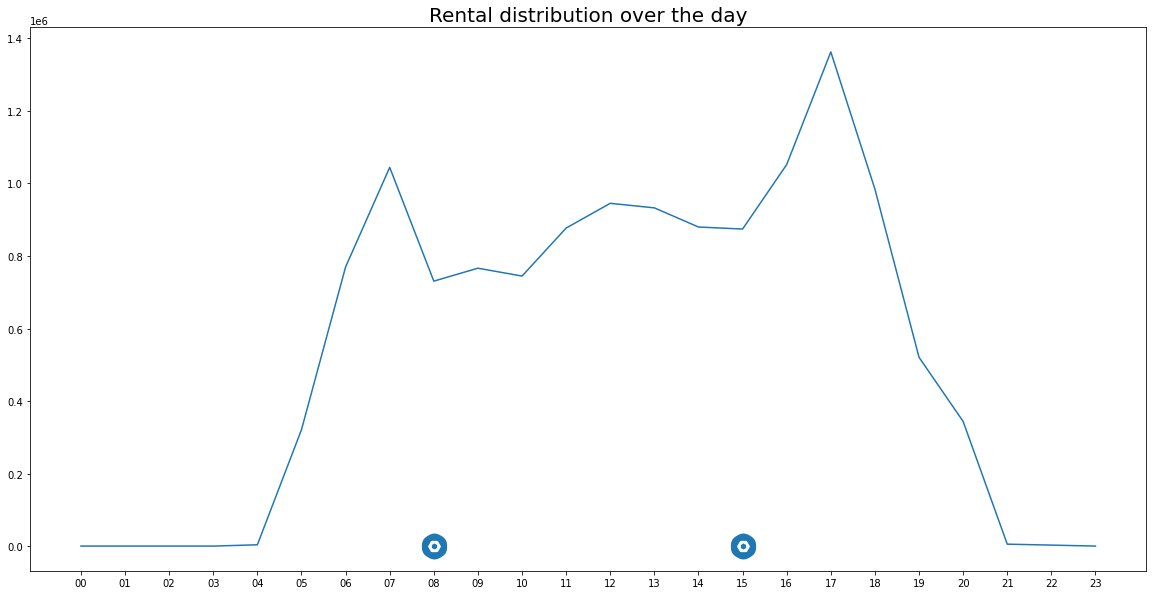

In [197]:
plt.figure(figsize=(20,10))
plt.plot(routes_by_hr.count_rentals)
plt.title('Rental distribution over the day', size=20)
plt.scatter([8,15], [1,1], marker='h', linewidths=20)

In [220]:
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = {i:row.routes.count(i) for i in row.routes}
    

KeyboardInterrupt: 

In [267]:
test_dict = routes_dict.copy()

In [269]:
test_dict

{'00': {'_24_12': 1},
 '01': {(59, 64): 3, '_59_60': 1, '_34_65': 1, '_1_20': 1, '_22_22': 1},
 '02': {'_67_66': 1,
  '_67_47': 1,
  '_67_60': 1,
  '_67_45': 1,
  '_67_5': 1,
  '_67_2': 1,
  '_67_19': 1,
  '_67_56': 1,
  '_31_31': 1,
  '_59_46': 1,
  '_34_32': 1},
 '03': {(62, 62): 1,
  (47, 7): 1,
  (47, 89): 1,
  '_67_5': 1,
  '__31_31': 1,
  '__66_44': 1,
  '__66_8': 1},
 '04': {(66, 24): 85,
  (7, 13): 112,
  (34, 67): 44,
  (7, 4): 91,
  (7, 12): 215,
  (7, 8): 243,
  (7, 2): 62,
  (7, 38): 207,
  (7, 10): 128,
  (7, 21): 181,
  (5, 5): 9,
  (5, 21): 1,
  (7, 9): 84,
  (7, 67): 129,
  (7, 6): 198,
  (7, 5): 100,
  (7, 22): 8,
  (16, 10): 8,
  (31, 31): 15,
  (7, 1): 43,
  (21, 13): 1,
  (16, 8): 13,
  (34, 43): 36,
  (7, 7): 470,
  (16, 64): 1,
  (16, 35): 1,
  (7, 49): 5,
  (59, 53): 1,
  (59, 19): 1,
  (2, 1): 75,
  (7, 54): 4,
  (7, 47): 2,
  (7, 70): 100,
  (16, 34): 2,
  (6, 6): 3,
  (16, 21): 9,
  (7, 20): 4,
  (3, 3): 3,
  (7, 43): 48,
  (3, 19): 4,
  (16, 12): 16,
  (16, 7

In [270]:
for k, v in test_dict.items():
    for key in v.keys():
        k_new = f"_{str(key).replace(', ', '_').replace('(', '').replace(')', '')}"
        print(k_new)
        test_dict[k][k_new] = test_dict[k].pop(key)
        k_new = ''

__24_12


RuntimeError: dictionary keys changed during iteration

<AxesSubplot:>

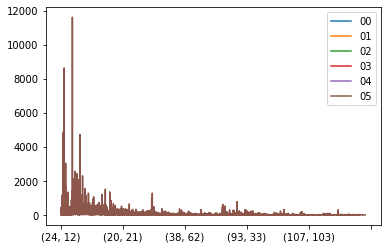

In [223]:
routes_usage = pd.DataFrame.from_dict(routes_dict, ind)
routes_usage.plot()

In [237]:
for i in routes_usage.columns:
    print(routes_usage[i].sort_values(ascending=False)[:10])

24  12    1.0
59  64    NaN
    60    NaN
45  65    NaN
1   10    NaN
22  22    NaN
67  66    NaN
    47    NaN
    60    NaN
    45    NaN
Name: 00, dtype: float64
59  64    3.0
    60    1.0
45  65    1.0
1   10    1.0
22  22    1.0
24  12    NaN
67  66    NaN
    47    NaN
    60    NaN
    45    NaN
Name: 01, dtype: float64
67  66    1.0
    47    1.0
    60    1.0
    45    1.0
    5     1.0
    2     1.0
    19    1.0
    56    1.0
31  31    1.0
59  46    1.0
Name: 02, dtype: float64
67  5     1.0
31  31    1.0
66  44    1.0
    8     1.0
62  62    1.0
47  7     1.0
    89    1.0
24  12    NaN
59  64    NaN
    60    NaN
Name: 03, dtype: float64
7  7     470.0
   8     243.0
   12    215.0
   38    207.0
   6     198.0
   21    181.0
   67    129.0
   10    128.0
   13    112.0
   23    108.0
Name: 04, dtype: float64
8   10    11608.0
7   70     8632.0
    5      4868.0
1   2      4721.0
23  66     3542.0
66  23     3040.0
8   47     2576.0
1   67     2424.0
8   11     2390.0
27 

## Pandemic analysis

In [ ]:
bike_df['month'] = bike_df.Fecha_Prestamo.dt.month

In [ ]:
bike_df.groupby('month').cout()['Fecha_Prestamo'].sort_values().plot()

## most used bike

In [114]:
# extract the most used bike for faster computation
most_used = bike_df.Id_Tag_Bicicleta.value_counts().keys()[0]
most_used_df = bike_df[bike_df.Id_Tag_Bicicleta == most_used]
most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')

<ipython-input-114-ac04865d68c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')


In [116]:
# assign routes as tuples
most_used_df = most_used_df.dropna()
most_used_df['routes'] = most_used_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)

<ipython-input-116-4bea5f5e66ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_used_df['routes'] = most_used_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)


In [128]:
day_df[day_df == day_df.max()].index[0]

'2017/06/16'

In [159]:
most_used_df.routes.value_counts()

(8, 10)     116
(10, 8)      82
(7, 5)       77
(2, 1)       76
(3, 3)       65
           ... 
(34, 19)      1
(35, 53)      1
(2, 48)       1
(55, 7)       1
(55, 40)      1
Name: routes, Length: 2127, dtype: int64

Busiest day 2017/06/16 with 50 rentals for ID 000017AFC4CF


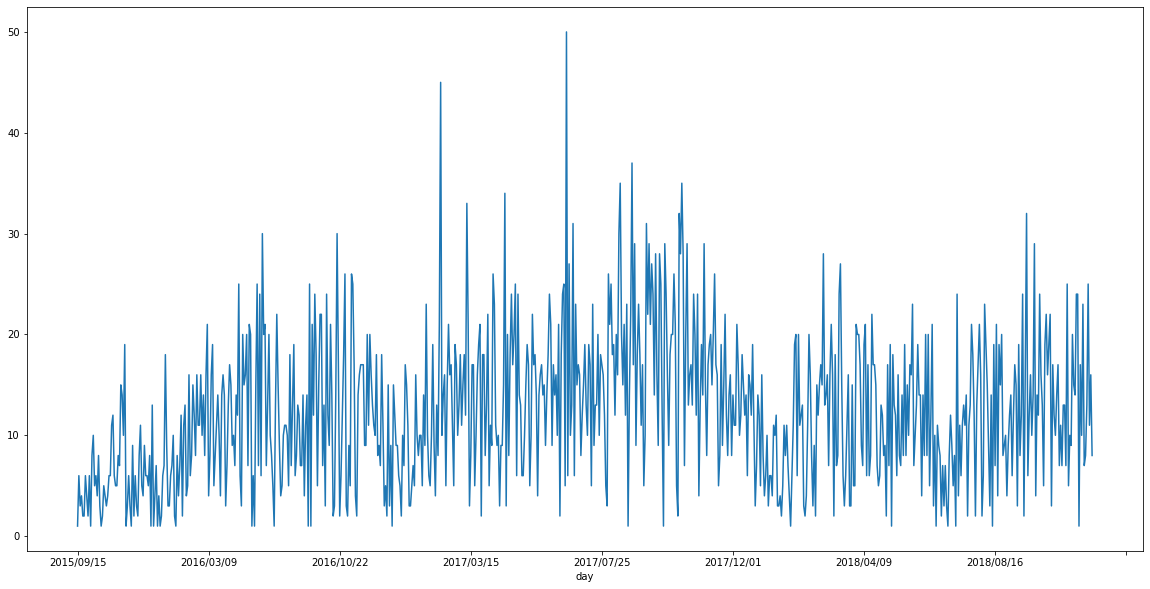

In [154]:
# follow the most used bike by day
day_df = most_used_df.groupby('day').count().sort_index()['Id_Usuario']
day_df.plot(figsize=(20,10))
print(f'Busiest day {day_df[day_df == day_df.max()].index[0]} with {day_df.max()} rentals for ID {most_used}')

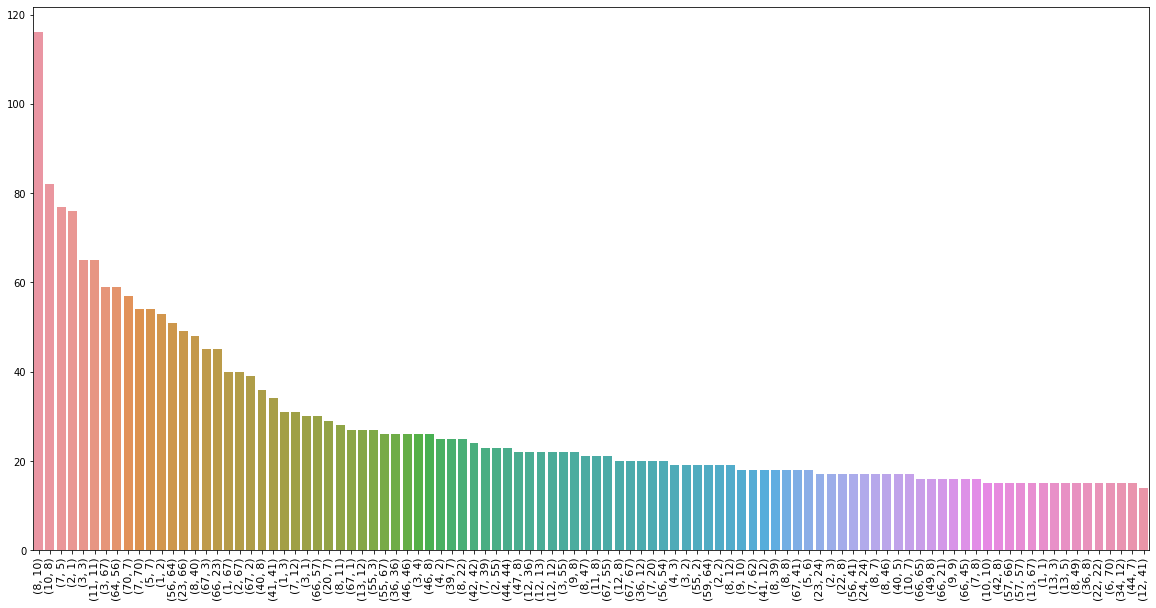

In [152]:
# by route
counts = most_used_df.routes.value_counts()[:100]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90, size=11)
plt.show()